this code has a good point about multi layer rnns in keras, whitch is writtem=n in 'design network' part. that is adding "return_sequences = True" in properties of first rnn layer.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from math import sqrt
import numpy
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import datetime
import sklearn
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from pandas import read_csv
from datetime import datetime
from google.colab import files

In [26]:
#load data
path="/content/drive/MyDrive/ETH-USD1.csv"
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
dataset = read_csv(path,  parse_dates = [0] ,  date_parser=parse)
dataset.drop('Date', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
dataset.index.name = 'date'
print(dataset.head(5))
# save to file
dataset.to_csv('/content/drive/MyDrive/ETH-USD2.csv')

            Open        High         Low       Close   Adj Close      Volume
date                                                                        
0     308.644989  329.451996  307.056000  320.884003  320.884003   893249984
1     320.670990  324.717987  294.541992  299.252991  299.252991   885985984
2     298.585999  319.453003  298.191986  314.681000  314.681000   842300992
3     314.690002  319.153015  298.513000  307.907990  307.907990  1613479936
4     307.024994  328.415009  307.024994  316.716003  316.716003  1041889984


1520


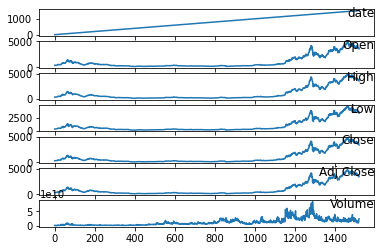

In [29]:
path1="/content/drive/MyDrive/ETH-USD2.csv"
dataset = read_csv(path1, header=0)
values = dataset.values
n_values=len(values)
print(n_values)
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5,6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [31]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
#load dataset
dataset = read_csv(path1, header=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...   var5(t)   var6(t)   var7(t)
1   0.000000   0.047477   0.473338  ...  0.045464  0.045464  0.003151
2   0.000658   0.050022   0.470704  ...  0.048727  0.048727  0.002630
3   0.001317   0.045348   0.466754  ...  0.047295  0.047295  0.011826
4   0.001975   0.048756   0.466096  ...  0.049158  0.049158  0.005010
5   0.002633   0.047134   0.472021  ...  0.053582  0.053582  0.005342

[5 rows x 14 columns]


In [32]:
# split into train and test sets
values = reframed.values
random.shuffle(values)
n_train =int(0.9*(n_values)) 
#sklearn.model_selection.train_test_split(values, train_size=n_train, test_size=16000)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, (0,1,2,3,4,6)], train[:, 5]
test_X, test_y = test[:, (0,1,2,3,4,6)], test[:, 5]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1368, 1, 6) (1368,) (151, 1, 6) (151,)


Epoch 1/180
43/43 - 6s - loss: 0.0152 - val_loss: 0.0371 - 6s/epoch - 149ms/step
Epoch 2/180
43/43 - 0s - loss: 0.0011 - val_loss: 0.0316 - 253ms/epoch - 6ms/step
Epoch 3/180
43/43 - 0s - loss: 3.5449e-04 - val_loss: 0.0292 - 266ms/epoch - 6ms/step
Epoch 4/180
43/43 - 0s - loss: 2.5529e-04 - val_loss: 0.0272 - 267ms/epoch - 6ms/step
Epoch 5/180
43/43 - 0s - loss: 1.8445e-04 - val_loss: 0.0263 - 266ms/epoch - 6ms/step
Epoch 6/180
43/43 - 0s - loss: 1.6389e-04 - val_loss: 0.0253 - 258ms/epoch - 6ms/step
Epoch 7/180
43/43 - 0s - loss: 2.5060e-04 - val_loss: 0.0234 - 261ms/epoch - 6ms/step
Epoch 8/180
43/43 - 0s - loss: 1.7785e-04 - val_loss: 0.0201 - 230ms/epoch - 5ms/step
Epoch 9/180
43/43 - 0s - loss: 1.6490e-04 - val_loss: 0.0181 - 258ms/epoch - 6ms/step
Epoch 10/180
43/43 - 0s - loss: 1.6759e-04 - val_loss: 0.0165 - 275ms/epoch - 6ms/step
Epoch 11/180
43/43 - 0s - loss: 1.9909e-04 - val_loss: 0.0155 - 276ms/epoch - 6ms/step
Epoch 12/180
43/43 - 0s - loss: 1.7415e-04 - val_loss: 0.0106

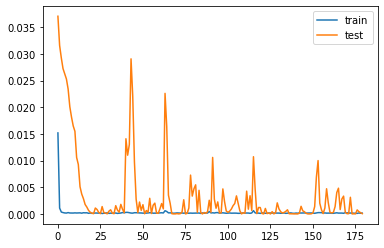

In [33]:
# design network
model = Sequential()
model.add(GRU(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences = True))
model.add(GRU(40))
model.add(Dense(1))
model.add(BatchNormalization())
model.compile(loss='mse', optimizer='adam')
#checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# fit network
history = model.fit(train_X, train_y, epochs=180, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

[[0.09997427]
 [0.3668969 ]
 [0.66068757]
 [0.05569634]
 [0.06887269]
 [0.1324217 ]
 [0.1062099 ]
 [0.02522549]
 [0.027877  ]
 [0.03701219]
 [0.04930264]
 [0.0828298 ]
 [0.0507994 ]
 [0.34783557]
 [0.18220529]
 [0.20134196]
 [0.02152976]
 [0.2102929 ]
 [0.223394  ]
 [0.07410473]
 [0.02242282]
 [0.40984073]
 [0.3206025 ]
 [0.12329072]
 [0.05110538]
 [0.09930781]
 [0.4824746 ]
 [0.08237496]
 [0.07205468]
 [0.02722183]
 [0.0291594 ]
 [0.09879863]
 [0.08415842]
 [0.089268  ]
 [0.22143844]
 [0.13691664]
 [0.0181165 ]
 [0.14632219]
 [0.07378909]
 [0.73493946]
 [0.0221982 ]
 [0.16172788]
 [0.2097384 ]
 [0.04730624]
 [0.09755799]
 [0.15983114]
 [0.4086198 ]
 [0.1534327 ]
 [0.04669496]
 [0.14715004]
 [0.13516232]
 [0.35855213]
 [0.03061399]
 [0.02169582]
 [0.03582743]
 [0.0146935 ]
 [0.03638864]
 [0.51507604]
 [0.02169582]
 [0.0403074 ]
 [0.0267911 ]
 [0.3053486 ]
 [0.02748057]
 [0.0363844 ]
 [0.677037  ]
 [0.06240997]
 [0.30189928]
 [0.04536337]
 [0.6322619 ]
 [0.02809933]
 [0.06493884]
 [0.02

No handles with labels found to put in legend.


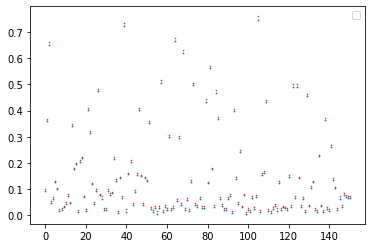

Test RMSE: 0.007


In [34]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# # calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#pyplot.plot(test_y)
#pyplot.plot(yhat)
pyplot.scatter(numpy.arange(len(test_y)), test_y, marker='*',s=1)
pyplot.scatter(numpy.arange(len(test_y)), yhat, marker='.',s=1, color="red")
print(yhat)
path2="/content/drive/MyDrive/output3.csv"
path3="/content/drive/MyDrive/y_real.csv"
numpy.savetxt(path2, yhat)
numpy.savetxt(path3, test_y)
#yhat.to_csv('output2.csv')
#yhat.to_csv(brandname + 'yhat.csv', sep='\t')
#files.download(brandname + 'yhat.csv')
pyplot.legend()
pyplot.show()
print('Test RMSE: %.3f' % rmse)

#save model
#model.save("ETH_model")

No handles with labels found to put in legend.


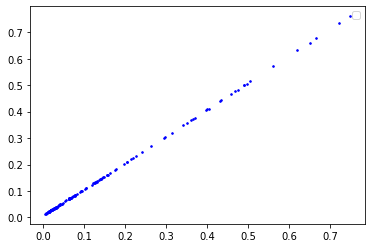

In [35]:
pyplot.scatter(test_y, yhat, color='blue', marker='.', s=10)
pyplot.legend()
pyplot.show()
